In [27]:
from diffusion import UNet, Noiser, show_images
import torch

In [10]:
n_samples=16
n_steps=1000
beta_min=0.0001
beta_max=0.02
time_emb_dim=100
model_path='diffusion.pth'
device = 'mps:0'

noiser = Noiser(device=device, n_steps=n_steps, beta_min=beta_min, beta_max=beta_max)
net = UNet(n_steps=n_steps, time_emb_dim=time_emb_dim).to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

UNet(
  (time_embed): Embedding(1000, 100)
  (te1): Linear(in_features=100, out_features=1, bias=True)
  (b1): Sequential(
    (0): ConvBlock(
      (ln): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
      (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): SiLU()
    )
    (1): ConvBlock(
      (ln): LayerNorm((10, 28, 28), eps=1e-05, elementwise_affine=True)
      (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): SiLU()
    )
    (2): ConvBlock(
      (ln): LayerNorm((10, 28, 28), eps=1e-05, elementwise_affine=True)
      (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): SiLU()
    )
  )
  (down1): Con

In [66]:
init_x = torch.randn(n_samples, 1, 28, 28).to(device)

100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 71.62it/s]


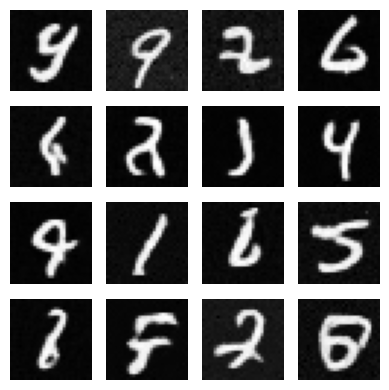

In [125]:
from tqdm import tqdm

ddim_step = 20
ts = torch.linspace(n_steps, 0, (ddim_step + 1)).to(torch.long).to(device)
eta = 1
with torch.no_grad():
    x = init_x
    for i in tqdm(range(ddim_step)): # 0,...,19
        cur_t = ts[i] - 1 # 999
        prev_t = ts[i+1] - 1 # 949
        
        time_tensor = (torch.ones(n_samples, 1).to(device) * cur_t).long()
        epislon = net(x, time_tensor)
        noise = torch.randn_like(x)

        ab_cur = noiser.alpha_bars[cur_t]
        ab_prev = noiser.alpha_bars[prev_t] if prev_t >= 0 else 1
        var = eta * torch.sqrt((1 - ab_prev) / (1 - ab_cur) * (1 - ab_cur / ab_prev))
        
        w1 = (ab_prev / ab_cur)**0.5
        w2 = (1 - ab_prev - var**2)**0.5 - (ab_prev * (1 - ab_cur) / ab_cur)**0.5
        w3 = var
        x = first_term * x + second_term * epislon + third_term * noise
        
        #x = ab_prev**0.5 * ((x - (1-ab_cur)**0.5 * epislon)/(ab_cur**0.5)) + (1-ab_prev)**0.5*epislon
show_images(x)

In [138]:
from einops import rearrange, repeat

class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = query_dim if context_dim is None else context_dim

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = x if context is None else context
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

ModuleNotFoundError: No module named 'einops'

In [148]:
a = nn.MultiheadAttention(2, 1)

In [149]:
r = torch.randn(100, 2)
c = torch.randn(100, 2)

In [150]:
a_v, _ = a(r, c, c)

In [152]:
print(a_v.shape)

torch.Size([100, 2])


In [147]:
2 // 2

1

In [153]:
0.75**2

0.5625